# Method 7 - Rest Ideas After 15

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 15].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

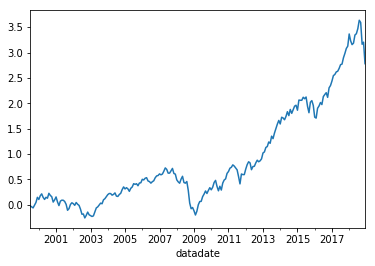

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.144516
2000-12-31   -0.044332
2001-12-31   -0.051948
2002-12-31   -0.228251
2003-12-31    0.446020
2004-12-31    0.166166
2005-12-31    0.060277
2006-12-31    0.100463
2007-12-31    0.017594
2008-12-31   -0.411004
2009-12-31    0.414375
2010-12-31    0.211166
2011-12-31   -0.014789
2012-12-31    0.194879
2013-12-31    0.398075
2014-12-31    0.112571
2015-12-31   -0.000797
2016-12-31    0.132237
2017-12-31    0.231865
2018-12-31   -0.083939
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     3102.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.19e-198
Time:                        22:03:27   Log-Likelihood:                 844.15
No. Observations:                 234   AIC:                            -1678.
Df Residuals:                     229   BIC:                            -1661.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.000      4.344      0.000       0.001       0.003
mktrf          1.0497      0.012     84.846      0.000       1.025       1.074
me             0.1932      0.014     13.423      0.000       0.165       0.222
ia             0.0480      0.022      2.196      0.029       0.005       0.091
roe           -0.0296      0.019     -1.579      0.116      -0.066       0.007
==============================================================================
Omnibus:                       20.824   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.668
Skew:                          -0.225   Prob(JB):                     2.02e-15
Kurtosis:                       5.596   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     2641.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.85e-190
Time:                        22:03:27   Log-Likelihood:                 844.15
No. Observations:                 234   AIC:                            -1678.
Df Residuals:                     229   BIC:                            -1661.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.000      4.103      0.000       0.001       0.003
mktrf          1.0497      0.014     73.165      0.000       1.022       1.078
me             0.1932      0.027      7.177      0.000       0.140       0.246
ia             0.0480      0.044      1.088      0.276      -0.038       0.135
roe           -0.0296      0.028     -1.038      0.299      -0.085       0.026
==============================================================================
Omnibus:                       20.824   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.668
Skew:                          -0.225   Prob(JB):                     2.02e-15
Kurtosis:                       5.596   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     2792.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.72e-193
Time:                        22:03:28   Log-Likelihood:                 844.15
No. Observations:                 234   AIC:                            -1678.
Df Residuals:                     229   BIC:                            -1661.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.000      4.042      0.000       0.001       0.003
mktrf          1.0497      0.014     75.403      0.000       1.022       1.077
me             0.1932      0.024      7.916      0.000       0.145       0.241
ia             0.0480      0.047      1.029      0.304      -0.043       0.140
roe           -0.0296      0.031     -0.945      0.344      -0.091       0.032
==============================================================================
Omnibus:                       20.824   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.668
Skew:                          -0.225   Prob(JB):                     2.02e-15
Kurtosis:                       5.596   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2185.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.22e-190
Time:                        22:03:28   Log-Likelihood:                 830.08
No. Observations:                 234   AIC:                            -1648.
Df Residuals:                     228   BIC:                            -1627.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.531      0.001       0.001       0.003
mktrf          1.0596      0.013     80.314      0.000       1.034       1.086
smb            0.2173      0.017     12.484      0.000       0.183       0.252
hml            0.0453      0.021      2.207      0.028       0.005       0.086
rmw           -0.0080      0.023     -0.343      0.732      -0.054       0.038
cma            0.0016      0.030      0.056      0.956      -0.056       0.060
==============================================================================
Omnibus:                       22.323   Durbin-Watson:                   1.729
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.925
Skew:                           0.009   Prob(JB):                     4.02e-21
Kurtosis:                       6.104   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1654.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.71e-177
Time:                        22:03:28   Log-Likelihood:                 830.08
No. Observations:                 234   AIC:                            -1648.
Df Residuals:                     228   BIC:                            -1627.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.516      0.000       0.001       0.003
mktrf          1.0596      0.015     70.604      0.000       1.030       1.089
smb            0.2173      0.024      9.018      0.000       0.170       0.265
hml            0.0453      0.041      1.106      0.269      -0.035       0.126
rmw           -0.0080      0.032     -0.248      0.804      -0.071       0.055
cma            0.0016      0.041      0.040      0.968      -0.079       0.083
==============================================================================
Omnibus:                       22.323   Durbin-Watson:                   1.729
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.925
Skew:                           0.009   Prob(JB):                     4.02e-21
Kurtosis:                       6.104   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1989.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.99e-186
Time:                        22:03:28   Log-Likelihood:                 830.08
No. Observations:                 234   AIC:                            -1648.
Df Residuals:                     228   BIC:                            -1627.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      3.357      0.001       0.001       0.003
mktrf          1.0596      0.015     71.118      0.000       1.030       1.089
smb            0.2173      0.021     10.438      0.000       0.177       0.258
hml            0.0453      0.042      1.083      0.279      -0.037       0.127
rmw           -0.0080      0.034     -0.232      0.817      -0.075       0.059
cma            0.0016      0.040      0.041      0.968      -0.077       0.081
==============================================================================
Omnibus:                       22.323   Durbin-Watson:                   1.729
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.925
Skew:                           0.009   Prob(JB):                     4.02e-21
Kurtosis:                       6.104   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2600.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.66e-189
Time:                        22:03:28   Log-Likelihood:                 823.91
No. Observations:                 234   AIC:                            -1638.
Df Residuals:                     229   BIC:                            -1621.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      3.926      0.000       0.001       0.003
mktrf          1.0510      0.012     84.621      0.000       1.027       1.075
smb            0.2108      0.016     13.594      0.000       0.180       0.241
hml            0.0781      0.015      5.072      0.000       0.048       0.108
umd           -0.0247      0.010     -2.445      0.015      -0.045      -0.005
==============================================================================
Omnibus:                       17.511   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.719
Skew:                          -0.047   Prob(JB):                     4.83e-13
Kurtosis:                       5.410   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2048.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.19e-178
Time:                        22:03:28   Log-Likelihood:                 823.91
No. Observations:                 234   AIC:                            -1638.
Df Residuals:                     229   BIC:                            -1621.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.123      0.002       0.001       0.003
mktrf          1.0510      0.017     62.630      0.000       1.018       1.084
smb            0.2108      0.023      9.183      0.000       0.166       0.256
hml            0.0781      0.043      1.805      0.071      -0.007       0.163
umd           -0.0247      0.018     -1.404      0.160      -0.059       0.010
==============================================================================
Omnibus:                       17.511   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.719
Skew:                          -0.047   Prob(JB):                     4.83e-13
Kurtosis:                       5.410   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2543.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.97e-188
Time:                        22:03:28   Log-Likelihood:                 823.91
No. Observations:                 234   AIC:                            -1638.
Df Residuals:                     229   BIC:                            -1621.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.912      0.004       0.001       0.003
mktrf          1.0510      0.015     69.951      0.000       1.022       1.080
smb            0.2108      0.023      9.143      0.000       0.166       0.256
hml            0.0781      0.048      1.629      0.103      -0.016       0.172
umd           -0.0247      0.015     -1.687      0.092      -0.053       0.004
==============================================================================
Omnibus:                       17.511   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.719
Skew:                          -0.047   Prob(JB):                     4.83e-13
Kurtosis:                       5.410   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     1523.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.44e-98
Time:                        22:03:28   Log-Likelihood:                 419.46
No. Observations:                 120   AIC:                            -828.9
Df Residuals:                     115   BIC:                            -815.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.602      0.000       0.001       0.004
mktrf          1.0508      0.019     54.372      0.000       1.012       1.089
me             0.1739      0.019      9.109      0.000       0.136       0.212
ia             0.1053      0.030      3.523      0.001       0.046       0.165
roe           -0.0452      0.026     -1.708      0.090      -0.098       0.007
==============================================================================
Omnibus:                       10.329   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               17.189
Skew:                          -0.361   Prob(JB):                     0.000185
Kurtosis:                       4.708   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     1533.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.00e-98
Time:                        22:03:28   Log-Likelihood:                 419.46
No. Observations:                 120   AIC:                            -828.9
Df Residuals:                     115   BIC:                            -815.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.092      0.002       0.001       0.004
mktrf          1.0508      0.021     49.635      0.000       1.009       1.092
me             0.1739      0.026      6.643      0.000       0.123       0.225
ia             0.1053      0.043      2.421      0.015       0.020       0.191
roe           -0.0452      0.031     -1.452      0.147      -0.106       0.016
==============================================================================
Omnibus:                       10.329   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               17.189
Skew:                          -0.361   Prob(JB):                     0.000185
Kurtosis:                       4.708   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2373.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.77e-109
Time:                        22:03:28   Log-Likelihood:                 419.46
No. Observations:                 120   AIC:                            -828.9
Df Residuals:                     115   BIC:                            -815.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.804      0.005       0.001       0.004
mktrf          1.0508      0.018     57.263      0.000       1.015       1.087
me             0.1739      0.024      7.112      0.000       0.126       0.222
ia             0.1053      0.038      2.803      0.005       0.032       0.179
roe           -0.0452      0.032     -1.414      0.157      -0.108       0.017
==============================================================================
Omnibus:                       10.329   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               17.189
Skew:                          -0.361   Prob(JB):                     0.000185
Kurtosis:                       4.708   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     991.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.60e-92
Time:                        22:03:28   Log-Likelihood:                 407.86
No. Observations:                 120   AIC:                            -803.7
Df Residuals:                     114   BIC:                            -787.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.334      0.001       0.001       0.004
mktrf          1.0974      0.023     48.678      0.000       1.053       1.142
smb            0.2220      0.026      8.693      0.000       0.171       0.273
hml            0.0236      0.031      0.755      0.452      -0.038       0.086
rmw            0.0254      0.037      0.688      0.493      -0.048       0.098
cma            0.0738      0.040      1.827      0.070      -0.006       0.154
==============================================================================
Omnibus:                       13.536   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               36.167
Skew:                          -0.272   Prob(JB):                     1.40e-08
Kurtosis:                       5.634   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1177.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.54e-96
Time:                        22:03:28   Log-Likelihood:                 407.86
No. Observations:                 120   AIC:                            -803.7
Df Residuals:                     114   BIC:                            -787.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.202      0.001       0.001       0.004
mktrf          1.0974      0.026     42.105      0.000       1.046       1.148
smb            0.2220      0.034      6.449      0.000       0.155       0.289
hml            0.0236      0.067      0.350      0.726      -0.108       0.156
rmw            0.0254      0.054      0.473      0.636      -0.080       0.131
cma            0.0738      0.045      1.627      0.104      -0.015       0.163
==============================================================================
Omnibus:                       13.536   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               36.167
Skew:                          -0.272   Prob(JB):                     1.40e-08
Kurtosis:                       5.634   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     2115.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.31e-110
Time:                        22:03:28   Log-Likelihood:                 407.86
No. Observations:                 120   AIC:                            -803.7
Df Residuals:                     114   BIC:                            -787.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.033      0.002       0.001       0.004
mktrf          1.0974      0.024     45.316      0.000       1.050       1.145
smb            0.2220      0.031      7.227      0.000       0.162       0.282
hml            0.0236      0.072      0.330      0.742      -0.117       0.164
rmw            0.0254      0.057      0.442      0.659      -0.087       0.138
cma            0.0738      0.042      1.744      0.081      -0.009       0.157
==============================================================================
Omnibus:                       13.536   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               36.167
Skew:                          -0.272   Prob(JB):                     1.40e-08
Kurtosis:                       5.634   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1155.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.17e-92
Time:                        22:03:28   Log-Likelihood:                 403.22
No. Observations:                 120   AIC:                            -796.4
Df Residuals:                     115   BIC:                            -782.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.973      0.000       0.002       0.005
mktrf          1.0599      0.019     54.373      0.000       1.021       1.098
smb            0.2119      0.022      9.547      0.000       0.168       0.256
hml            0.1045      0.022      4.701      0.000       0.060       0.149
umd           -0.0264      0.014     -1.929      0.056      -0.054       0.001
==============================================================================
Omnibus:                       10.732   Durbin-Watson:                   1.770
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               22.815
Skew:                          -0.251   Prob(JB):                     1.11e-05
Kurtosis:                       5.076   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1429.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.14e-97
Time:                        22:03:28   Log-Likelihood:                 403.22
No. Observations:                 120   AIC:                            -796.4
Df Residuals:                     115   BIC:                            -782.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.619      0.000       0.001       0.005
mktrf          1.0599      0.026     41.486      0.000       1.010       1.110
smb            0.2119      0.027      7.908      0.000       0.159       0.264
hml            0.1045      0.053      1.959      0.050   -7.51e-05       0.209
umd           -0.0264      0.021     -1.283      0.199      -0.067       0.014
==============================================================================
Omnibus:                       10.732   Durbin-Watson:                   1.770
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               22.815
Skew:                          -0.251   Prob(JB):                     1.11e-05
Kurtosis:                       5.076   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2298.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.11e-108
Time:                        22:03:28   Log-Likelihood:                 403.22
No. Observations:                 120   AIC:                            -796.4
Df Residuals:                     115   BIC:                            -782.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.370      0.001       0.001       0.005
mktrf          1.0599      0.020     53.060      0.000       1.021       1.099
smb            0.2119      0.028      7.567      0.000       0.157       0.267
hml            0.1045      0.058      1.813      0.070      -0.008       0.217
umd           -0.0264      0.017     -1.596      0.110      -0.059       0.006
==============================================================================
Omnibus:                       10.732   Durbin-Watson:                   1.770
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               22.815
Skew:                          -0.251   Prob(JB):                     1.11e-05
Kurtosis:                       5.076   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     2207.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.71e-103
Time:                        22:03:28   Log-Likelihood:                 450.79
No. Observations:                 114   AIC:                            -891.6
Df Residuals:                     109   BIC:                            -877.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      3.031      0.003       0.000       0.002
mktrf          1.0496      0.014     75.255      0.000       1.022       1.077
me             0.2349      0.022     10.909      0.000       0.192       0.278
ia            -0.1182      0.030     -3.957      0.000      -0.177      -0.059
roe           -0.0506      0.026     -1.927      0.057      -0.103       0.001
==============================================================================
Omnibus:                        7.676   Durbin-Watson:                   2.259
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.384
Skew:                          -0.529   Prob(JB):                       0.0249
Kurtosis:                       3.660   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     3125.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.97e-111
Time:                        22:03:28   Log-Likelihood:                 450.79
No. Observations:                 114   AIC:                            -891.6
Df Residuals:                     109   BIC:                            -877.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      4.037      0.000       0.001       0.002
mktrf          1.0496      0.012     90.828      0.000       1.027       1.072
me             0.2349      0.019     12.155      0.000       0.197       0.273
ia            -0.1182      0.028     -4.176      0.000      -0.174      -0.063
roe           -0.0506      0.024     -2.074      0.038      -0.098      -0.003
==============================================================================
Omnibus:                        7.676   Durbin-Watson:                   2.259
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.384
Skew:                          -0.529   Prob(JB):                       0.0249
Kurtosis:                       3.660   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     3124.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.01e-111
Time:                        22:03:28   Log-Likelihood:                 450.79
No. Observations:                 114   AIC:                            -891.6
Df Residuals:                     109   BIC:                            -877.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      4.466      0.000       0.001       0.002
mktrf          1.0496      0.011     92.623      0.000       1.027       1.072
me             0.2349      0.019     12.623      0.000       0.198       0.271
ia            -0.1182      0.030     -3.925      0.000      -0.177      -0.059
roe           -0.0506      0.025     -2.035      0.042      -0.099      -0.002
==============================================================================
Omnibus:                        7.676   Durbin-Watson:                   2.259
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.384
Skew:                          -0.529   Prob(JB):                       0.0249
Kurtosis:                       3.660   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2901.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.49e-113
Time:                        22:03:28   Log-Likelihood:                 479.33
No. Observations:                 114   AIC:                            -946.7
Df Residuals:                     108   BIC:                            -930.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.951      0.054   -1.15e-05       0.001
mktrf          1.0479      0.010    100.718      0.000       1.027       1.069
smb            0.1900      0.017     11.248      0.000       0.156       0.223
hml            0.0391      0.022      1.816      0.072      -0.004       0.082
rmw           -0.1498      0.026     -5.680      0.000      -0.202      -0.098
cma           -0.1755      0.033     -5.241      0.000      -0.242      -0.109
==============================================================================
Omnibus:                        0.661   Durbin-Watson:                   2.412
Prob(Omnibus):                  0.719   Jarque-Bera (JB):                0.760
Skew:                          -0.169   Prob(JB):                        0.684
Kurtosis:                       2.787   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2488.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.33e-110
Time:                        22:03:28   Log-Likelihood:                 479.33
No. Observations:                 114   AIC:                            -946.7
Df Residuals:                     108   BIC:                            -930.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      2.688      0.007       0.000       0.001
mktrf          1.0479      0.012     89.442      0.000       1.025       1.071
smb            0.1900      0.017     11.300      0.000       0.157       0.223
hml            0.0391      0.021      1.834      0.067      -0.003       0.081
rmw           -0.1498      0.018     -8.561      0.000      -0.184      -0.116
cma           -0.1755      0.033     -5.289      0.000      -0.241      -0.110
==============================================================================
Omnibus:                        0.661   Durbin-Watson:                   2.412
Prob(Omnibus):                  0.719   Jarque-Bera (JB):                0.760
Skew:                          -0.169   Prob(JB):                        0.684
Kurtosis:                       2.787   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2928.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.50e-113
Time:                        22:03:28   Log-Likelihood:                 479.33
No. Observations:                 114   AIC:                            -946.7
Df Residuals:                     108   BIC:                            -930.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      2.544      0.011       0.000       0.001
mktrf          1.0479      0.011     94.118      0.000       1.026       1.070
smb            0.1900      0.016     11.840      0.000       0.159       0.221
hml            0.0391      0.020      1.940      0.052      -0.000       0.079
rmw           -0.1498      0.019     -7.998      0.000      -0.187      -0.113
cma           -0.1755      0.031     -5.624      0.000      -0.237      -0.114
==============================================================================
Omnibus:                        0.661   Durbin-Watson:                   2.412
Prob(Omnibus):                  0.719   Jarque-Bera (JB):                0.760
Skew:                          -0.169   Prob(JB):                        0.684
Kurtosis:                       2.787   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2242.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.17e-103
Time:                        22:03:28   Log-Likelihood:                 451.68
No. Observations:                 114   AIC:                            -893.4
Df Residuals:                     109   BIC:                            -879.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.559      0.577      -0.001       0.001
mktrf          1.0612      0.013     80.915      0.000       1.035       1.087
smb            0.2250      0.020     11.003      0.000       0.184       0.266
hml           -0.0124      0.021     -0.588      0.558      -0.054       0.029
umd           -0.0260      0.016     -1.639      0.104      -0.058       0.005
==============================================================================
Omnibus:                        0.833   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.659   Jarque-Bera (JB):                0.787
Skew:                          -0.199   Prob(JB):                        0.675
Kurtosis:                       2.912   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1893.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.06e-99
Time:                        22:03:28   Log-Likelihood:                 451.68
No. Observations:                 114   AIC:                            -893.4
Df Residuals:                     109   BIC:                            -879.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.670      0.503      -0.001       0.001
mktrf          1.0612      0.016     66.791      0.000       1.030       1.092
smb            0.2250      0.017     13.289      0.000       0.192       0.258
hml           -0.0124      0.020     -0.606      0.544      -0.052       0.028
umd           -0.0260      0.021     -1.246      0.213      -0.067       0.015
==============================================================================
Omnibus:                        0.833   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.659   Jarque-Bera (JB):                0.787
Skew:                          -0.199   Prob(JB):                        0.675
Kurtosis:                       2.912   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     3190.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.45e-112
Time:                        22:03:28   Log-Likelihood:                 451.68
No. Observations:                 114   AIC:                            -893.4
Df Residuals:                     109   BIC:                            -879.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.780      0.435      -0.000       0.001
mktrf          1.0612      0.015     69.368      0.000       1.031       1.091
smb            0.2250      0.013     17.668      0.000       0.200       0.250
hml           -0.0124      0.017     -0.724      0.469      -0.046       0.021
umd           -0.0260      0.022     -1.197      0.231      -0.069       0.017
==============================================================================
Omnibus:                        0.833   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.659   Jarque-Bera (JB):                0.787
Skew:                          -0.199   Prob(JB):                        0.675
Kurtosis:                       2.912   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""